# Train ANN with DSM2 data

## Define Hyper-Parameters

In [2]:
''' 
Select NN architecture from:
MLP, LSTM, GRU, ResNet, Res-LSTM, Res-GRU, Transformer
'''
model_type ='Res-LSTM'

''' 
Numbers of neurons in the main branch
 - Provide two numbers for MLP, ResNet, Res-LSTM, Res-GRU, 
 - Provide one number for LSTM, GRU.
 '''
num_neurons_multiplier=[8, 2]

'''
Number of training epochs (Note: training will stop when reaching this number 
or test loss doesn't decrease for 50 epochs)
'''
epochs = 500

'''
Dataset to be split for training and test
'''
data_file = "observed_data_daily.xlsx"

'''
Ratio to split the dataset for training
'''
train_ratio = 0.7
'''
Which part of dataset used for for testing
Available options: {'first', 'last', 'first_n_last', 'manual'}
'''
which_part_for_training = 'last'

'''
Dictionary of extra test sets
- keys: test scenario name
- values: names of excel files
'''
extra_test_sets = {'dcc0':"dsm2_ann_inputs_dcc0.xlsx",
                   'smscg1':"dsm2_ann_inputs_smscg1.xlsx",
                   'dcc1':"dsm2_ann_inputs_dcc1.xlsx",
                   'smscg0':"dsm2_ann_inputs_smscg0.xlsx",}
                   
'''
Whether to use hourly Martinez Stage as additional input
'''
use_hourly_stage_input = False

''' 
Whether to (True) train models from scratch or (False) evaluate pre-trained models
'''
train_models = True

'''Whether to save evaluation results (metric values, figures) to Google Drive'''
save_results = True

############################################
############  Siyu's Notes:  ###############
############################################
'''
In the pickle file, numerical results will be saved with the following suffixes:
-- Training results (chronologically-split observed data): '_train'
-- Test results (chronologically-split observed data): '_test'
-- Results on addtional augmented data (defined by extra_test_sets): '_extra_test'
'''




####################################################
########## End of hyper-param definitions ##########
####################################################

initial_lr=0.001
batch_size = 128


'''
Define the model architecture: (input layer will be build automatically)

Supported abbreviation-layer pairs (detailed definitions can be found in "Layer builders" section)
- 'lstm': keras.layers.LSTM
- 'res': resnet block (basic_1d)
- 'c1d': keras.layers.Conv1D
- 'td': keras.layers.TimeDistributed
- 'dr': keras.layers.Dropout
- 'f': keras.layers.Flatten
- 'g': keras.layers.GRU
- 'd': keras.layers.Dense 
- 'o': keras.layers.Dense

Usage of resnet blocks: res(num_of_filters)x(kernel_size)x(stride)x(stages)
stages: # of resnet units in the block
example: model_str_def = 'res10x3x1x1_f_d8_d2_o1'

Usage of 1D conv layers: c1d(num_of_filters)x(kernel_size)x(stride)
example: model_str_def = 'c1d10x3x1_c1d10x3x1_f_d8_d2_o1'

'''
model_type = model_type.lower()

if model_type =='mlp':
    ## 1. MLP Network
    model_str_def = 'd8_d2_o1'

elif model_type =='lstm':
    # 2. LSTM Network
    model_str_def = 'lstm%d_f_o1' % (num_neurons_multiplier[0])

elif model_type =='gru':
    # 3. GRU Network
    model_str_def = 'g%d_f_o1' % (num_neurons_multiplier[0])

elif model_type =='resnet':
    # 4. ResNet
    model_str_def = 'resnet%s' % ('_' + '_'.join([str(ii) for ii in num_neurons_multiplier]))
    num_res_blocks=1

elif model_type =='res-lstm':
    # 5. Res-LSTM
    model_str_def = 'residual_lstm%s' % ('_' + '_'.join([str(ii) for ii in num_neurons_multiplier]))

elif model_type =='res-gru':
    # 6. Res-GRU
    model_str_def = 'residual_gru%s' % ('_' + '_'.join([str(ii) for ii in num_neurons_multiplier]))

elif model_type =='transformer':
    # 7. Transformer
    model_str_def = 'transformer'
else:
    raise "Model %s is not supported" % model_type


if model_type =='mlp':
    # pre-processing option 1: apply pre-defined average windowing:
    ndays=8
    window_size=11
    nwindows=10
else:
    # pre-processing option 2: directly use daily measurements as inputs
    ndays=118
    window_size=0
    nwindows=0

if 'daily' in data_file:
    interval = '1D'
elif 'hourly' in data_file:
    interval = '1h'
else:
    raise "Data file %s is not supported in this script" % data_file

print('Dataset: %s' % data_file)

# percentile thresholds for ranged results
percentiles = [0,0.75,0.95]  

picked_training_years = [('1990-10-1','1991-9-30'),
                         ('1992-10-1','1995-9-30'),
                         ('1996-10-1','1998-9-30'),
                         ('1999-10-1','2003-9-30'),
                         ('2004-10-1','2006-9-30'),
                         ('2007-10-1','2010-9-30'),
                         ('2011-10-1','2013-9-30'),
                         ('2014-10-1','2016-9-30'),
                         ('2017-10-1','2019-9-30'),]
resume_training = False


Dataset: observed_data_daily.xlsx


## Install Packages

In [3]:
import os
import sys
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates
import datetime
import time

import numpy as np
import pandas as pd
!pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
#import keras
from sklearn.preprocessing import MinMaxScaler


## Read Data

In [4]:
from google.colab import drive
google_drive_dir = 'SalinityMLWorkshop_DMS_UCD-main'
drive.mount('/content/drive',force_remount=True)
local_root_path = os.path.join('/content/drive','My Drive',google_drive_dir)

num_sheets = 9
num_dataset = {"observed_data_daily.xlsx":'daily',
               "observed_data_hourly.xlsx":'hourly'}
sys.path.append(local_root_path)
import annutils
data_path = os.path.join(local_root_path,data_file)

### Read Stations

In [5]:
if data_file != "observed_data_daily.xlsx":
    # sorted by EC median, small to large
    observed_stations_ordered_by_median = ['RSMKL008', 'RSAN032', 'RSAN037', 'RSAC092', 'SLTRM004', 'ROLD024',
                                           'CHVCT000', 'RSAN018', 'CHSWP003', 'CHDMC006', 'SLDUT007', 'RSAN072',
                                           'OLD_MID', 'RSAN058', 'ROLD059', 'RSAN007', 'RSAC081', 'SLMZU025',
                                           'RSAC075', 'SLMZU011', 'SLSUS012', 'SLCBN002', 'RSAC064']
else:
    dfouts=pd.read_excel(data_path,num_sheets-1,index_col=0,parse_dates=True)

    output_stations_w_duplicates_for_time = dfouts.columns[~dfouts.columns.str.contains('_dup')]
    observed_stations_ordered_by_median = list(set(output_stations_w_duplicates_for_time))
    print('Found %d stations:' % len(observed_stations_ordered_by_median))
    print(observed_stations_ordered_by_median)

station_orders = {s:ii for ii, s in enumerate(observed_stations_ordered_by_median)}

Found 23 stations:
['RSAC075', 'RSAN072', 'RSAN032', 'RSAN007', 'SLTRM004', 'CHVCT000', 'RSAN037', 'RSAC081', 'SLSUS012', 'RSAC092', 'SLCBN002', 'RSAC064', 'SLDUT007', 'CHSWP003', 'OLD_MID', 'CHDMC006', 'ROLD059', 'RSAN058', 'ROLD024', 'SLMZU011', 'SLMZU025', 'RSMKL008', 'RSAN018']


### (Optional) Read Hourly Martinez Stage as Additional Input

In [6]:
if use_hourly_stage_input:
    assert len(extra_test_sets) == 0, 'Cannot include extra test sets when incorporating Martinez hourly stage in inputs'
    martinez = pd.read_csv(os.path.join(local_root_path, "martinez_stage1hr.csv"),comment='#', parse_dates=['Time'], index_col='Time')

### Read Test Sets


*   Test Split from Base Data (Defined by *data_file*, split according to )
*   Augmented Data (Defined in *extra_test_sets*)

In [7]:
output_stations = None


xscaler = None
yscaler = None

for file in list(extra_test_sets.values()) + [data_file]:
    data_path = os.path.join(local_root_path,file)

    dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

    df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    if output_stations is None:
        if len(extra_test_sets) > 0:
            # read station names
            output_stations = list(dfouts.columns)
            name_mapping = {}
            for s in output_stations:
                for ss in observed_stations_ordered_by_median:
                    if ss in s:
                        name_mapping[s] = ss
            output_stations = list(name_mapping.values())
        else:
            output_stations = observed_stations_ordered_by_median
    
    output_stations = [x for x in sorted(output_stations, key=lambda s: station_orders[s.split('-')[0]],reverse=False)]

    if file in extra_test_sets.values():
        dfouts = dfouts.rename(columns=name_mapping)[output_stations]
    else:
        dfouts = dfouts[output_stations]
    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    if xscaler is None:
        xscaler,yscaler = annutils.create_xyscaler([dfinps],[dfouts])
    else:
        temp_xscaler,temp_yscaler = annutils.create_xyscaler([dfinps],[dfouts])
        if np.any(np.isnan(temp_xscaler.max_val)) or np.any(np.isnan(temp_yscaler.max_val)):
            break
        xscaler.update(temp_xscaler)
        yscaler.update(temp_yscaler)

x_extrat = None
y_extrat = None

for file in extra_test_sets.values():
    data_path = os.path.join(local_root_path,file)

    dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

    df_inpout = pd.concat(dflist[0:num_sheets],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = dfouts.rename(columns=name_mapping)[output_stations]

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    if x_extrat is None:
        (x_extrat, y_extrat), (_, _), _, _ = \
            annutils.create_training_sets([dfinps],
                                          [dfouts],
                                          train_frac=1,
                                          ndays=ndays,window_size=window_size,nwindows=nwindows,
                                          xscaler=xscaler,yscaler=yscaler)
    else:
        (xt, yt), (_, _), _, _ = \
            annutils.create_training_sets([dfinps],
                                          [dfouts],
                                          train_frac=1,
                                          ndays=ndays,window_size=window_size,nwindows=nwindows,
                                          xscaler=xscaler,yscaler=yscaler)
        x_extrat = pd.concat([x_extrat,xt],axis=0)
        y_extrat = pd.concat([y_extrat,yt],axis=0)
        del xt, yt

Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test


### Load Training Set

In [8]:
data_path = os.path.join(local_root_path,data_file)
dflist = [pd.read_excel(data_path,i,index_col=0,parse_dates=True) for i in range(num_sheets)]

if data_file == "observed_data_1h.xlsx":
    index = pd.date_range(start=dfouts.index[0].date(), end=dfouts.index[-2].date(), freq='D')
    df2 = pd.DataFrame(dfouts.loc[:,observed_stations_ordered_by_median][index[0]:(index[-1] + pd.Timedelta('23 h'))].values.reshape([len(index),24*len(output_stations)]),
                       columns=['%s-%d' % (station, ii) for ii in range(24) for station in observed_stations_ordered_by_median],
                       index=index)
    output_col_list = df2.columns
    df_inpout = pd.concat(dflist[0:(num_sheets-1)]+[df2],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(output_col_list)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(output_col_list)]
    del df2
else:
    df_inpout = pd.concat(dflist[0:(num_sheets)],axis=1).dropna(axis=0)
    dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = df_inpout.loc[:,df_inpout.columns.isin(dflist[num_sheets-1].columns)]
    dfouts = dfouts[output_stations]


In [9]:
if use_hourly_stage_input:
    index = pd.date_range(start=dfouts.index[0].date(), end=dfouts.index[-1].date(), freq='D')
    martinez_input = pd.DataFrame(martinez[index[0]:(index[-1] + pd.Timedelta('23 h'))].values.reshape([-1,24]),
                        columns=['Martinez_Stage-%d' % ii for ii in range(24)],
                        index=index)
    stage_scaler = annutils.myscaler()
    _ = stage_scaler.fit_transform(martinez_input)
    normalized_martinez_input = stage_scaler.transform(martinez_input)

In [10]:
dfinps

,northern_flow,sjr_flow,exports,/HIST+GATE/RSAC128/POS/01JAN1953 - 01JAN2020/IR-YEAR/DWR-DMS-DSM2/,div+seep-drain_dcd+smcd,daily_max-min,sjr_vernalis_ec,sac_greens_ec
2000-01-01,14954.00,1581.000000,10535.7,1.0,2069.44,5.1,829.60,167.08
2000-01-02,14928.00,1581.000000,10489.3,1.0,2104.34,5.4,824.50,164.17
2000-01-03,14998.00,1581.000000,10557.0,1.0,2092.58,5.7,819.40,169.58
2000-01-04,14746.00,1631.000000,10639.4,1.0,2077.37,5.9,814.20,166.67
2000-01-05,14681.00,1674.000000,10758.0,1.0,2035.92,6.1,809.10,170.00
...,...,...,...,...,...,...,...,...
2019-12-27,19995.57,2345.708252,10677.0,0.0,1614.06,6.4,605.81,179.46
2019-12-28,19178.19,2338.458252,11272.0,0.0,1377.12,6.1,656.82,182.79
2019-12-29,18651.57,2322.088623,10927.0,0.0,747.41,5.7,631.26,184.52
2019-12-30,18096.47,2310.291748,10325.0,0.0,414.61,5.2,643.28,185.60


In [11]:
dfouts

,RSAC075,RSAN072,RSAN032,RSAN007,SLTRM004,CHVCT000,RSAN037,RSAC081,SLSUS012,RSAC092,...,CHSWP003,OLD_MID,CHDMC006,ROLD059,RSAN058,ROLD024,SLMZU011,SLMZU025,RSMKL008,RSAN018
2000-01-01,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
2000-01-02,7169.864130,-2.000000,106.520833,1758.072917,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,410.656250,...,-2.000000,899.968750,530.885417,-2.000000,-2.000000,-2.000000,9546.875000,-2.000000,175.750000,580.260418
2000-01-03,6549.184783,-2.000000,103.468750,1657.489583,-2.000000,-2.000000,-2.000000,3492.006250,-2.000000,374.010416,...,-2.000000,892.083333,560.114584,-2.000000,-2.000000,-2.000000,9502.604167,-2.000000,171.531250,563.083334
2000-01-04,6601.141304,-2.000000,102.385417,1844.593684,-2.000000,-2.000000,-2.000000,3354.670168,-2.000000,469.680000,...,-2.000000,906.427083,501.718750,-2.000000,-2.000000,-2.000000,9641.875000,-2.000000,167.864583,585.821051
2000-01-05,7710.029771,-2.000000,111.083333,1975.729167,-2.000000,-2.000000,-2.000000,3649.512816,-2.000000,430.270833,...,-2.000000,878.958333,491.854167,-2.000000,-2.000000,-2.000000,9831.770833,-2.000000,176.385417,632.114584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,5826.927083,634.364583,342.489583,-2.000000,462.604167,332.854167,345.864583,2418.104167,7720.145833,310.302083,...,416.286458,639.083333,455.062500,687.468750,602.968750,427.833333,8447.697917,6019.458333,196.270833,657.614583
2019-12-28,5117.729167,648.114583,329.062500,-2.000000,443.364583,335.770833,341.500000,1991.656250,7621.979167,307.802083,...,428.161458,656.750000,472.354167,697.718750,644.770833,443.270833,8405.416667,5926.854167,196.000000,645.322917
2019-12-29,4882.864583,664.062500,328.031250,-2.000000,424.979167,342.291667,339.135417,1830.187500,7538.031250,308.885417,...,438.223958,652.552083,483.083333,718.250000,650.885417,439.927083,8397.437500,5802.781250,191.656250,641.562500
2019-12-30,4832.671264,661.187500,329.708333,-2.000000,424.218750,347.927083,335.510417,1883.322917,7326.812500,272.500000,...,434.765625,631.729167,480.906250,735.562500,632.385417,446.635417,8325.843750,5637.583333,188.864583,629.322917


## Setup Training and Test Periods

In [12]:
start_year = max(dfinps.index[0].year, dfouts.index[0].year)
end_year = min(dfinps.index[-1].year, dfouts.index[-1].year)
if data_file == "observed_data_daily.xlsx":
    calib_slice = slice(str(start_year), str(int(start_year+train_ratio*(end_year-start_year))))
    valid_slice = slice(str(int(start_year+train_ratio*(end_year-start_year))+1), str(end_year))
else:
    if which_part_for_training =='first':
        calib_slice = slice(str(start_year), str(int(start_year+train_ratio*(end_year-start_year))))
        valid_slice = slice(str(int(start_year+train_ratio*(end_year-start_year))+1), str(end_year))
    elif which_part_for_training =='last':
        calib_slice = slice(str(int(start_year+(1-train_ratio)*(end_year-start_year))+1), str(end_year))
        valid_slice = slice(str(start_year), str(int(start_year+(1-train_ratio)*(end_year-start_year))))
    elif which_part_for_training =='first_n_last':
        calib_slice = [slice(str(start_year),
                             str(int(start_year+train_ratio/2*(end_year-start_year)))),
                       slice(str(int(start_year+(1-train_ratio/2)*(end_year-start_year))+1),
                             str(end_year))]
        valid_slice = slice(str(int(start_year+train_ratio/2*(end_year-start_year))+1),
                            str(int(start_year+(1-train_ratio/2)*(end_year-start_year))))
    elif which_part_for_training =='manual' and picked_training_years is not None:
        calib_slice = [slice(str(start_year), str(end_year)) for (start_year,end_year) in picked_training_years]
        valid_slice = [slice(start_year, end_year) for ((_,start_year),(end_year,_)) in zip([(None,'1989-10-1'),]+picked_training_years,picked_training_years+[('2020-9-30',None),])]
    else:
        raise Exception('Unknown data splitting method')
print('Training set:', calib_slice)
print('Test set:', valid_slice)

Training set: slice('2000', '2013', None)
Test set: slice('2014', '2019', None)


## Model Definitions

### ResNet Block Building Function

In [13]:
parameters = {
    "kernel_initializer": "he_normal"
}

def basic_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
    force_identity_shortcut=False
):
    """
    A one-dimensional basic block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        if block != 0 or stage == 0:
            stride = 1
        else:
            stride = 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2a".format(stage_char, block_char))(x)
        y = keras.layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu", name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block != 0 or force_identity_shortcut:
            shortcut = x
        else:
            shortcut = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])
        
        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f


def bottleneck_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
):
    """
    A one-dimensional bottleneck block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        stride = 1 if block != 0 or stage == 0 else 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2b_relu".format(stage_char, block_char))(y)

        y = keras.layers.Conv1D(filters * 4, 1, use_bias=False,
                                name="res{}{}_branch2c".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block == 0:
            shortcut = keras.layers.Conv1D(filters * 4, 1, strides=stride, use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        else:
            shortcut = x

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])
        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f

### Layer Builders

In [14]:
"""# Custom loss function"""
def mse_loss_masked(y_true, y_pred):
    squared_diff = tf.reduce_sum(tf.math.squared_difference(y_pred[y_true>0],y_true[y_true>0]))
    return squared_diff/(tf.reduce_sum(tf.cast(y_true>0, tf.float32))+0.01)

# Define Sequential model
NFEATURES = (num_sheets-1) # * (ndays + nwindows) 
def build_layer_from_string_def(s='i120',width_multiplier=1,
                                block=0,
                                force_identity_shortcut=False,
                                return_sequences_rnn=True):
    if s[0:4] == 'lstm':
        return layers.LSTM(units = int(s[4:])*width_multiplier, return_sequences=return_sequences_rnn, activation='sigmoid')
    elif s[0:3] == 'res':
        fields = s[3:].split('x')
        return basic_1d(filters=int(fields[0]),
                        stage=int(fields[3]),
                        block=block,
                        kernel_size=int(fields[1]),
                        stride=int(fields[2]),
                        force_identity_shortcut=force_identity_shortcut)
    elif s[0:3] == 'c1d':
        fields = s[3:].split('x')
        return keras.layers.Conv1D(filters=int(fields[0]), kernel_size=int(fields[1]), strides=int(fields[2]),
                                   padding='causal', activation='linear')
    elif s[0:2] == 'td':
        return keras.layers.TimeDistributed(keras.layers.Dense(int(s[2:]), activation='elu'))
    elif s[0:2] == 'dr':
        return keras.layers.Dropout(float(s[2:]))
    # elif s[0] == 'i':
    #     return keras.layers.InputLayer(input_shape=[int(s[1:]), NFEATURES])
    elif s[0] == 'f':
        return keras.layers.Flatten()
    elif s[0] == 'g':
        return keras.layers.GRU(int(s[1:])*width_multiplier, return_sequences=return_sequences_rnn, activation='relu')
    elif s[0] == 'd':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='elu')
    elif s[0] == 'o':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='linear')
    else:
        raise Exception('Unknown layer def: %s' % s)

### Model Builder

In [15]:
def build_model_from_string_def(strdef='i120_f_d4_d2_d1',width_multiplier=1):
    layer_strings = strdef.split('_')
    inputs = keras.layers.Input(shape=[int(layer_strings[0][1:]) * NFEATURES + 24 * use_hourly_stage_input])
    x = None
    prev_conv_output_num_of_channels = None
    return_sequences_rnn = None
    for block,f in enumerate(layer_strings[1:-1]):
        if x is None:
            if f.startswith(('lstm','g')):         
                # these layers require 2D inputs and permutation
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
                x = layers.Permute((2,1))(x)
                # return_sequences_rnn = layer_strings[block+2].startswith(('lstm','g','res','c1d'))
                return_sequences_rnn = True
            elif f.startswith(('res','c1d')):
                # these layers require 2D inputs
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
            else:
                x = inputs


        x = build_layer_from_string_def(f,width_multiplier,block,
                                        force_identity_shortcut=(f.startswith('res') and prev_conv_output_num_of_channels==int(f[3:].split('x')[0])),
                                        return_sequences_rnn=return_sequences_rnn)(x)
        if f.startswith('lstm'):         
            prev_conv_output_num_of_channels=int(f[4:])
        elif f.startswith('res') or f.startswith('c1d'):
            prev_conv_output_num_of_channels=int(f[3:].split('x')[0])


    outputs = keras.layers.Dense(int(layer_strings[-1][1:])*width_multiplier, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_resnet_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',
                       filters=num_sheets-1, kernel_size=3, stride=1,
                       num_res_blocks=1):
    inputs = layers.Input(shape=NFEATURES* (ndays + nwindows) + 24 * use_hourly_stage_input)
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    for ii in range(num_res_blocks - 1):
        # TODO: think about conv filter numbers and kernel sizes
        intermediate_features = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" %ii)(x)
        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2a" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2a_relu" % ii)(intermediate_features)

        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2b" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2b_relu" % ii)(intermediate_features)

        shortcut = x
        x = layers.Add(name="res%d_add" % ii)([intermediate_features, shortcut])

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" % num_res_blocks)(x)
    y = layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res%d_branch2a" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu", name="res%d_branch2a_relu" % num_res_blocks)(y)

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2b" % num_res_blocks)(y)
    y = layers.Conv1D(filters,kernel_size,use_bias=False,
                            name="res%d_branch2b" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)

    shortcut = inputs
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)

    y = layers.Add(name="res%d_add" % num_res_blocks)([y, shortcut])
    
    y = layers.Activation("relu",name="res_relu")(y)


    y = layers.Dense(nhidden2, activation=act_func)(y)
    outputs= layers.Dense(output_shape, activation=keras.activations.linear,name='output')(y)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_residual_lstm_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',layer_type='lstm',conv_init=None):
    rnn_layer = layers.LSTM if layer_type == 'lstm' else layers.GRU
    if use_hourly_stage_input:
        inputs = layers.Input(shape=NFEATURES*(ndays+nwindows) + 24)
        intermediate = layers.Reshape((NFEATURES*(ndays+nwindows) + 24, 1))(inputs)
        first_half = tf.keras.layers.Cropping1D(cropping=(0,24))(intermediate)
        x = layers.Reshape((ndays+nwindows,num_sheets-1))(first_half)

        second_half = tf.keras.layers.Cropping1D(cropping=(NFEATURES*(ndays+nwindows),0))(intermediate)
    else:
        inputs = layers.Input(shape=NFEATURES*(ndays+nwindows))
        x = layers.Reshape((ndays+nwindows,num_sheets-1))(inputs)
    x = layers.Permute((2,1))(x)

    y = tf.keras.layers.Conv1D(8+10,1, activation='relu',
                            kernel_initializer=conv_init,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
                            trainable=False)(x)

    y = layers.Flatten()(y)
    if use_hourly_stage_input:
        y = tf.keras.layers.concatenate([y,tf.keras.layers.Reshape((24,))(second_half)])
    y = layers.Dense(nhidden1, activation=act_func)(y)
    y = layers.Dense(nhidden2, activation=act_func)(y)
    y = layers.Dense(output_shape, activation=keras.activations.linear,name='mlp_output')(y)


    shortcut = layers.Dense(nhidden1, activation=act_func)(x)
    shortcut = rnn_layer(units = output_shape*2, activation=act_func,return_sequences=True)(shortcut)
    shortcut = layers.Flatten()(shortcut)
    shortcut = layers.Dense(output_shape, activation=keras.activations.linear,name='lstm_output')(shortcut)
    if use_hourly_stage_input:
        stage_shortcut = layers.Reshape((1,24))(second_half)
        stage_shortcut = rnn_layer(units = output_shape*2, activation=act_func,return_sequences=True)(stage_shortcut)
        stage_shortcut = layers.Flatten()(stage_shortcut)
        stage_shortcut = layers.Dense(output_shape, activation=keras.activations.linear,name='lstm_stage_output')(stage_shortcut)
        shortcut = layers.Add(name="stage_add")([shortcut,stage_shortcut])

    outputs = layers.Add(name="res_add")([y, shortcut])
    # outputs = layers.Activation("relu",name="res_relu")(outputs)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(head_size,
                      num_heads,
                      ff_dim,
                      num_transformer_blocks,
                      mlp_units,
                      output_shape,
                      dropout=0,
                      mlp_dropout=0):
    inputs = keras.Input(shape=NFEATURES*(ndays+nwindows) + 24 * use_hourly_stage_input)
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(output_shape)(x)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

Re-order stations

In [16]:
group_stations = False
station_without_groups = {'all':output_stations}
station_with_groups = {'G1':['SSS','RSAC101','RSMKL008'],
                  'G2':['Old_River_Hwy_4','Middle_River_Intake','CCWD_Rock','SLTRM004','RSAN032','RSAN037','SLDUT007','ROLD024','RSAN058','RSAN072','OLD_MID','ROLD059','CHDMC006','CHSWP003','CHVCT000'],
                  'G3':['SLCBN002','SLSUS012','SLMZU011','SLMZU025','RSAC064','RSAC075','RSAC081','RSAN007','RSAC092','RSAN018','Martinez']}
final_groups = {False: station_without_groups, 
                True: station_with_groups}

## Train Models

In [17]:
full_model_str_def = 'i%d_'%(ndays + nwindows) +model_str_def
if train_models:
    for group_name, stations in final_groups[group_stations].items():
        # prepare dataset
        selected_output_variables = []
        for station in stations:
            for output in output_stations:
                if station in output:
                    if interval == '1h':
                        selected_output_variables.extend(['%s-%d' % (output, hh) for hh in range(24)])
                    elif interval == '1D':
                        selected_output_variables.append(output)
        
        selected_output_variables = [x for x in sorted(selected_output_variables, key=lambda s: station_orders[s.split('-')[0]],reverse=False)]

        model_path_prefix = "mtl_%s_%s_%s_%s" % (group_name, ('stage_n_' if use_hourly_stage_input else '') + full_model_str_def, num_dataset[data_file],which_part_for_training+'_chronological')

        print('Training MTL ANN for %d stations: ' % len(selected_output_variables))

        print([station.replace('target/','').replace('target','') for station in selected_output_variables])
        

        (xallc, yallc), (xallv, yallv), _, _ = \
        annutils.create_training_sets([dfinps],
                                    [dfouts[output_stations]],
                                    calib_slice=calib_slice,
                                    valid_slice=valid_slice,
                                    ndays=ndays,window_size=window_size,nwindows=nwindows,
                                    xscaler=xscaler, yscaler=yscaler)
        if use_hourly_stage_input:
            xallc = pd.merge(xallc,normalized_martinez_input, left_index=True, right_index=True)
            xallv = pd.merge(xallv,normalized_martinez_input, left_index=True, right_index=True)

        if model_str_def.startswith('resnet'):
            model = build_resnet_model(nhidden1=num_neurons_multiplier[0]*yallc.shape[1], nhidden2=num_neurons_multiplier[1]*yallc.shape[1], output_shape=yallc.shape[1],
                                        num_res_blocks=num_res_blocks)
        elif model_str_def.startswith('residual_lstm') or model_str_def.startswith('residual_gru'):
            conv_init = tf.constant_initializer(annutils.conv_filter_generator(ndays=8,window_size=11,nwindows=10))

            model = build_residual_lstm_model(num_neurons_multiplier[0]*len(output_stations),
                                    num_neurons_multiplier[1]*len(output_stations),
                                    output_shape=yallc.shape[1],
                                    act_func='sigmoid',
                                    layer_type=model_str_def.lower().split('_')[1],
                                    conv_init=conv_init)
        elif model_str_def == 'transformer':
            model = build_transformer(head_size=256,
                                    num_heads=4,
                                    ff_dim=4,
                                    num_transformer_blocks=4,
                                    mlp_units=[128],
                                    output_shape=yallc.shape[1],
                                    mlp_dropout=0.4,
                                    dropout=0.25)
        else:
            model = build_model_from_string_def(full_model_str_def,width_multiplier=yallc.shape[1])


        display(model.summary())
        start_time = time.time()
        history = model.fit(
            xallc,
            yallc,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(xallv, yallv),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=100, mode="min", restore_best_weights=True),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=50, min_lr=1e-6, verbose=1),
            ],
            verbose=2
        )
        print('Finished training %d epochs in %.2f seconds' % (history.epoch[-1], time.time() - start_time))
        if save_results:
            model_savepath = os.path.join(local_root_path, 'models', (model_path_prefix))
            annutils.save_model(model_savepath, model, xscaler, yscaler)
            print('Model saved to %s' % model_savepath)

Training MTL ANN for 23 stations: 
['RSAC075', 'RSAN072', 'RSAN032', 'RSAN007', 'SLTRM004', 'CHVCT000', 'RSAN037', 'RSAC081', 'SLSUS012', 'RSAC092', 'SLCBN002', 'RSAC064', 'SLDUT007', 'CHSWP003', 'OLD_MID', 'CHDMC006', 'ROLD059', 'RSAN058', 'ROLD024', 'SLMZU011', 'SLMZU025', 'RSMKL008', 'RSAN018']
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 944)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 118, 8)       0           ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 8, 118)       0           ['reshape[0][0]']          

None

Epoch 1/500
40/40 - 3s - loss: 0.0497 - val_loss: 0.0401 - lr: 0.0010 - 3s/epoch - 68ms/step
Epoch 2/500
40/40 - 0s - loss: 0.0184 - val_loss: 0.0328 - lr: 0.0010 - 315ms/epoch - 8ms/step
Epoch 3/500
40/40 - 0s - loss: 0.0136 - val_loss: 0.0275 - lr: 0.0010 - 302ms/epoch - 8ms/step
Epoch 4/500
40/40 - 0s - loss: 0.0109 - val_loss: 0.0256 - lr: 0.0010 - 309ms/epoch - 8ms/step
Epoch 5/500
40/40 - 0s - loss: 0.0097 - val_loss: 0.0218 - lr: 0.0010 - 307ms/epoch - 8ms/step
Epoch 6/500
40/40 - 0s - loss: 0.0087 - val_loss: 0.0212 - lr: 0.0010 - 311ms/epoch - 8ms/step
Epoch 7/500
40/40 - 0s - loss: 0.0081 - val_loss: 0.0198 - lr: 0.0010 - 311ms/epoch - 8ms/step
Epoch 8/500
40/40 - 0s - loss: 0.0077 - val_loss: 0.0186 - lr: 0.0010 - 335ms/epoch - 8ms/step
Epoch 9/500
40/40 - 0s - loss: 0.0076 - val_loss: 0.0199 - lr: 0.0010 - 318ms/epoch - 8ms/step
Epoch 10/500
40/40 - 0s - loss: 0.0071 - val_loss: 0.0178 - lr: 0.0010 - 325ms/epoch - 8ms/step
Epoch 11/500
40/40 - 0s - loss: 0.0068 - val_loss: 

Epoch 87/500
40/40 - 0s - loss: 0.0036 - val_loss: 0.0139 - lr: 0.0010 - 309ms/epoch - 8ms/step
Epoch 88/500
40/40 - 0s - loss: 0.0034 - val_loss: 0.0153 - lr: 0.0010 - 324ms/epoch - 8ms/step
Epoch 89/500
40/40 - 0s - loss: 0.0036 - val_loss: 0.0139 - lr: 0.0010 - 318ms/epoch - 8ms/step
Epoch 90/500
40/40 - 0s - loss: 0.0034 - val_loss: 0.0136 - lr: 0.0010 - 327ms/epoch - 8ms/step
Epoch 91/500
40/40 - 0s - loss: 0.0034 - val_loss: 0.0139 - lr: 0.0010 - 314ms/epoch - 8ms/step
Epoch 92/500
40/40 - 0s - loss: 0.0034 - val_loss: 0.0137 - lr: 0.0010 - 320ms/epoch - 8ms/step
Epoch 93/500
40/40 - 0s - loss: 0.0036 - val_loss: 0.0135 - lr: 0.0010 - 327ms/epoch - 8ms/step
Epoch 94/500
40/40 - 0s - loss: 0.0034 - val_loss: 0.0159 - lr: 0.0010 - 312ms/epoch - 8ms/step
Epoch 95/500
40/40 - 0s - loss: 0.0035 - val_loss: 0.0143 - lr: 0.0010 - 320ms/epoch - 8ms/step
Epoch 96/500
40/40 - 0s - loss: 0.0033 - val_loss: 0.0142 - lr: 0.0010 - 339ms/epoch - 8ms/step
Epoch 97/500
40/40 - 0s - loss: 0.0034 -

Epoch 172/500
40/40 - 0s - loss: 0.0025 - val_loss: 0.0145 - lr: 0.0010 - 299ms/epoch - 7ms/step
Epoch 173/500
40/40 - 0s - loss: 0.0025 - val_loss: 0.0141 - lr: 0.0010 - 297ms/epoch - 7ms/step
Epoch 174/500
40/40 - 0s - loss: 0.0026 - val_loss: 0.0144 - lr: 0.0010 - 291ms/epoch - 7ms/step
Epoch 175/500
40/40 - 0s - loss: 0.0025 - val_loss: 0.0139 - lr: 0.0010 - 295ms/epoch - 7ms/step
Epoch 176/500
40/40 - 0s - loss: 0.0025 - val_loss: 0.0144 - lr: 0.0010 - 347ms/epoch - 9ms/step
Epoch 177/500
40/40 - 0s - loss: 0.0025 - val_loss: 0.0145 - lr: 0.0010 - 395ms/epoch - 10ms/step
Epoch 178/500
40/40 - 0s - loss: 0.0025 - val_loss: 0.0142 - lr: 0.0010 - 405ms/epoch - 10ms/step
Epoch 179/500

Epoch 179: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
40/40 - 0s - loss: 0.0024 - val_loss: 0.0143 - lr: 0.0010 - 339ms/epoch - 8ms/step
Epoch 180/500
40/40 - 0s - loss: 0.0024 - val_loss: 0.0140 - lr: 8.0000e-04 - 301ms/epoch - 8ms/step
Epoch 181/500
40/40 - 0s - loss: 0.0024 - v

In [18]:
# with tf.GradientTape() as tape:
#   # Forward pass
#   y = model(xallc.values)
#   loss = tf.reduce_mean(y**2)

# # Calculate gradients with respect to every trainable variable
# grad = tape.gradient(loss, model.trainable_variables)
# print(loss)
# # print(grad)

# Evaluation

## Define Evaluation Metrics

In [19]:
from collections import defaultdict
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE']

def evaluate_sequences(target, pred, metrics):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    valid_entries = target>0
    sequence_length = np.sum(valid_entries)
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))

    eval_results = defaultdict(float)
    
    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            eval_results[m] = np.sum(np.abs((pred-np.mean(pred)) * (target - np.mean(target)))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
    return eval_results

## Compute Numerical Results

In [20]:
# for daily resolution
if interval =='1D':
    full_results={}
    range_results=defaultdict(defaultdict)


    df_inpout = pd.concat(dflist[0:(num_sheets)],axis=1).dropna(axis=0)
    for group_name, stations in final_groups[group_stations].items():
        print('Testing MTL ANN for %d stations: ' % len(output_stations))


        model_path_prefix = "mtl_%s_%s_%s_%s" % (group_name, full_model_str_def, num_dataset[data_file],which_part_for_training+'_chronological')

        # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
        (xallc, yallc), (xallv, yallv), _, _ = \
            annutils.create_training_sets([dfinps],
                                        [dfouts[output_stations]],
                                        calib_slice=calib_slice,
                                        valid_slice=valid_slice,
                                        ndays=ndays,window_size=window_size,nwindows=nwindows,
                                        xscaler=xscaler, yscaler=yscaler)
        
        annmodel = annutils.load_model(os.path.join(local_root_path,'models', (model_path_prefix)),custom_objects={"mse_loss_masked": mse_loss_masked})

        train_pred = annmodel.model.predict(xallc,verbose=0)
        test_pred = annmodel.model.predict(xallv,verbose=0)
        extra_test_pred = annmodel.model.predict(x_extrat,verbose=0)
        
        all_target = np.concatenate((yallc,yallv),axis=0)
        all_pred = np.concatenate((train_pred,test_pred),axis=0)
        extra_test_target = y_extrat.to_numpy()

        for ii, location in enumerate(selected_output_variables):
            # compute training results
            train_results = evaluate_sequences(train_pred[:,ii], yallc.iloc[:,ii], eval_metrics)
            train_results['R^2'] = r2_score(train_pred[:,ii], yallc.iloc[:,ii])
            full_results['%s_train' %location] = train_results

            # compute test results
            eval_results = evaluate_sequences(test_pred[:,ii], yallv.iloc[:,ii], eval_metrics)
            eval_results['R^2'] = r2_score(test_pred[:,ii], yallv.iloc[:,ii])
            full_results['%s_test' %location] = eval_results

            # compute results on extra test data (augmented)
            extra_test_results = evaluate_sequences(extra_test_pred[:,ii], y_extrat.iloc[:,ii], eval_metrics)
            extra_test_results['R^2'] = r2_score(extra_test_pred[:,ii], y_extrat.iloc[:,ii])
            full_results['%s_extra_test' %location] = extra_test_results

            # compute results at different EC ranges on the complete base dataset (defined by data_file)
            for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
                lower_threshold = np.quantile(all_target[:,ii], lower_quantile)
                upper_threshold = np.quantile(all_target[:,ii], upper_quantile)
                eval_results = evaluate_sequences(all_target[(all_target[:,ii] > lower_threshold) & (all_target[:,ii] <= upper_threshold),ii],
                                                    all_pred[(all_target[:,ii] > lower_threshold) & (all_target[:,ii] <= upper_threshold),ii],
                                                    eval_metrics)
                range_results[location][lower_quantile*100] = eval_results

Testing MTL ANN for 23 stations: 


In [21]:
# for hourly resolution
if interval =='1h':
    full_results={}
    range_results=defaultdict(defaultdict)


    df_inpout = pd.concat(dflist[0:(num_sheets)],axis=1).dropna(axis=0)
    for group_name, stations in final_groups[group_stations].items():
        # prepare dataset
        selected_output_variables = []
        for station in stations:
            for output in output_stations:
                if station in output:
                    if station in output:
                        selected_output_variables.append(output)

        print('Testing MTL ANN for %d stations: ' % len(selected_output_variables))

        model_path_prefix = "mtl_%s_%s_%s_%s" % (group_name, ('stage_n_' if use_hourly_stage_input else '') + full_model_str_def, num_dataset[data_file],which_part_for_training+'_chronological')

        # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
        (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
            annutils.create_training_sets([dfinps],
                                        [dfouts[['%s-%d' % (output, hh) for hh in range(24) for output in selected_output_variables]]],
                                        calib_slice=calib_slice,
                                        valid_slice=valid_slice,
                                        ndays=ndays,window_size=window_size,nwindows=nwindows,)
        
        if use_hourly_stage_input:
            xallc = pd.merge(xallc,normalized_martinez_input, left_index=True, right_index=True)
            xallv = pd.merge(xallv,normalized_martinez_input, left_index=True, right_index=True)

        annmodel = annutils.load_model(os.path.join(local_root_path,'models', (model_path_prefix)),custom_objects={"mse_loss_masked": mse_loss_masked})

        train_pred = annmodel.model.predict(xallc,verbose=0)
        test_pred = annmodel.model.predict(xallv,verbose=0)
        
        all_target = np.concatenate((yallc,yallv),axis=0)
        all_pred = np.concatenate((train_pred,test_pred),axis=0)

        for ii, location in enumerate(selected_output_variables):
            train_results = None
            eval_results = None
            
            for hh in range(24):
                location_with_hour_name = '%s-%d' % (output, hh) 
        
            # compute training results
            partial_train_results = evaluate_sequences(train_pred[:,ii*24+hh],
                                                yallc.loc[:,location_with_hour_name],
                                                eval_metrics)
            partial_train_results['R^2'] = r2_score(train_pred[:,ii*24+hh], yallc.loc[:,location_with_hour_name])


            # compute training results
            partial_eval_results = evaluate_sequences(test_pred[:,ii*24+hh], yallv.loc[:,location_with_hour_name], eval_metrics)
            partial_eval_results['R^2'] = r2_score(test_pred[:,ii*24+hh], yallv.loc[:,location_with_hour_name])

            if train_results is None:
                train_results = partial_train_results
                eval_results = partial_eval_results
            else:
                for k in train_results.keys():
                    train_results[k] += partial_train_results[k]/24
                    eval_results[k] += partial_eval_results[k]/24

            full_results['%s_train' %location] = train_results
            full_results['%s_test' %location] = eval_results

            # compute results at different EC ranges on the complete base dataset (defined by data_file)
            for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
                lower_threshold = np.quantile(all_target[:,ii*24:(ii*24+23)].reshape(-1,), lower_quantile)
                upper_threshold = np.quantile(all_target[:,ii*24:(ii*24+23)].reshape(-1,), upper_quantile)
                current_target = all_target[:,ii*24:(ii*24+23)]
                current_pred = all_pred[:,ii*24:(ii*24+23)]
                eval_results = evaluate_sequences(current_target[(current_target > lower_threshold) & (current_target <= upper_threshold)].reshape(-1,),
                                                    current_pred[(current_target > lower_threshold) & (current_target <= upper_threshold)].reshape(-1,),
                                                    eval_metrics)
                range_results[location][lower_quantile*100] = eval_results

## Save Numerical Results to Google Drive

In [22]:
import pickle

if save_results:
    # create a pickle file on Google Drive and write results 
    result_path_prefix = "mtl_%s_%s_%s_%s" % (group_name, ('stage_n_' if use_hourly_stage_input else '') + full_model_str_def, num_dataset[data_file],which_part_for_training+'_chronological')
    results_path = os.path.join(local_root_path,"results/%s_full_results.pkl" % (result_path_prefix))

    f = open(results_path,"wb")
    pickle.dump(full_results,f)
    f.close()
    print('Numerical results saved to %s' % results_path)

    ### Uncomment below if you want to save results at different ranges ###

    # range_results_path = os.path.join(local_root_path,"results/%s_ranged_results.pkl" % (result_path_prefix))

    # f = open(range_results_path,"wb")
    # pickle.dump(range_results,f)
    # f.close()
    # print('Ranged numerical results saved to %s' % range_results_path)

Numerical results saved to .\results/mtl_all_i118_residual_lstm_8_2_daily_last_chronological_full_results.pkl


## Generate Plots

### Exceedance Probability Plots and Time Series Plots for Key Stations

In [23]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

Testing MTL ANN for 23 stations: 
['RSAC075', 'RSAN072', 'RSAN032', 'RSAN007', 'SLTRM004', 'CHVCT000', 'RSAN037', 'RSAC081', 'SLSUS012', 'RSAC092', 'SLCBN002', 'RSAC064', 'SLDUT007', 'CHSWP003', 'OLD_MID', 'CHDMC006', 'ROLD059', 'RSAN058', 'ROLD024', 'SLMZU011', 'SLMZU025', 'RSMKL008', 'RSAN018']
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 944)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 118, 8)       0           ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 8, 118)       0           ['reshape[0][0]']           

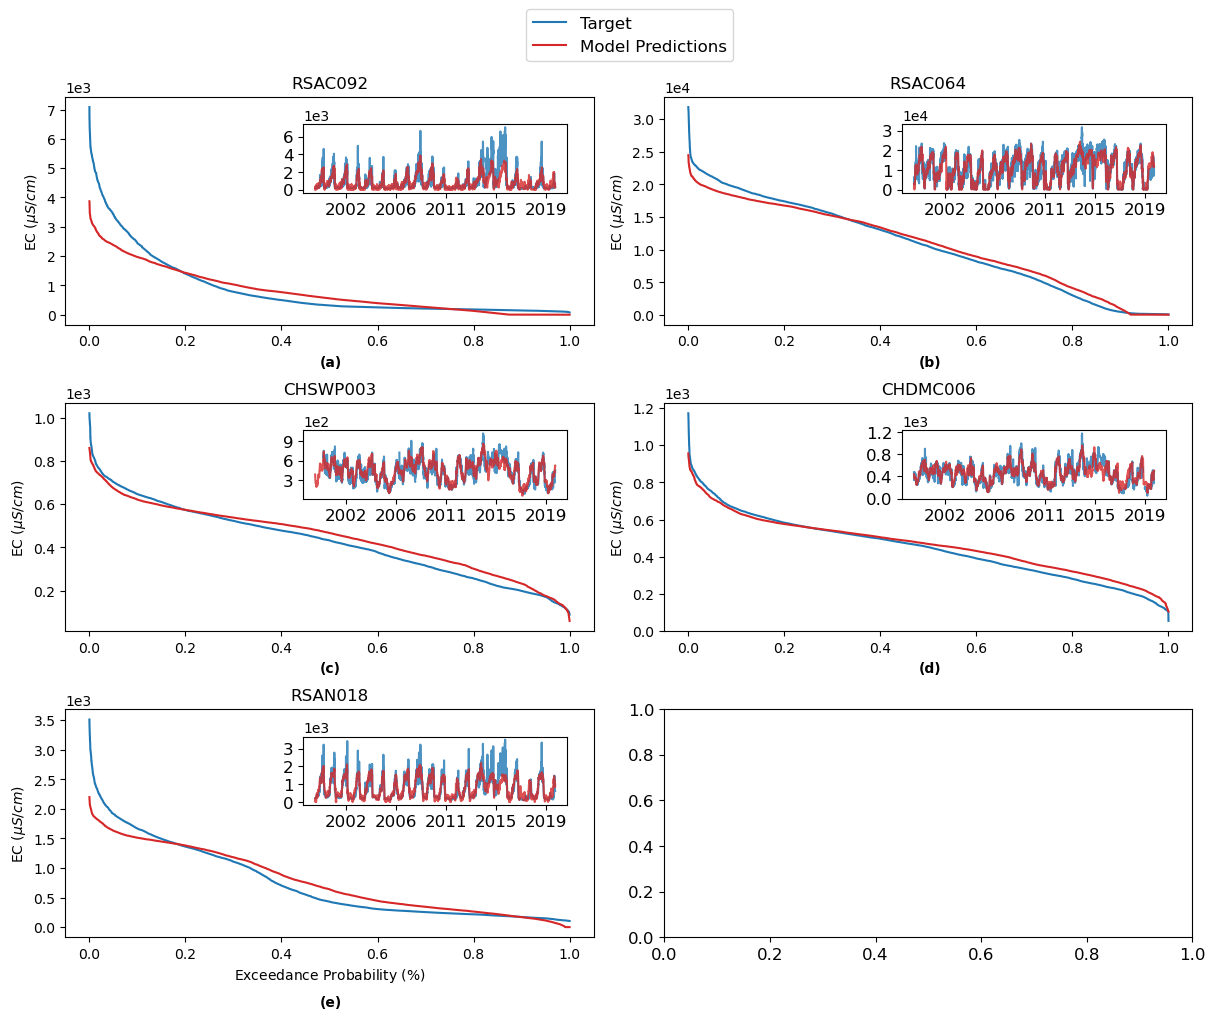

In [24]:
if (interval.lower() == '1d') and (data_file == "observed_data_daily.xlsx"):
    key_stations = ['RSAC064','CCWD_Rock','CHDMC006', 'CHSWP003','RSAC092','RSAN018']
else:
    key_stations = ['RSAC064','CHDMC006', 'CHSWP003','RSAC092','RSAN018','ROLD024']


key_station_mappings = {'JerseyPoint':'Jersey Point',
                        'Emmaton':'Emmaton',
                        'CCFBIntake':'CCFB Intake',
                        'CVPIntake':'CVP Intake',
                        'SLMZU025':'SLMZU025',
                        'ROLD059':'ROLD059'}

ncols=2
fig_combined_exceedance, ax_combined_exceedance = plt.subplots(nrows=len(key_stations)//ncols,
                                                               ncols=ncols,
                                                               figsize=(6*ncols,3*len(key_stations)//ncols))
fig_combined_exceedance.tight_layout(h_pad=3.5, w_pad=2)
ii = 0
for group_name, stations in final_groups[group_stations].items():
    # prepare dataset
    selected_output_variables = []
    for station in stations:
        for output in output_stations:
            if station in output:
                selected_output_variables.append(output)

    selected_output_variables = [x for x in sorted(selected_output_variables, key=lambda s: station_orders[s.split('-')[0]],reverse=False)]

    print('Testing MTL ANN for %d stations: ' % len(selected_output_variables))

    print([station.replace('target/','').replace('target','') for station in selected_output_variables])
    
    model_path_prefix = "mtl_%s_%s_%s_%s" % (group_name, ('stage_n_' if use_hourly_stage_input else '') + full_model_str_def, num_dataset[data_file],which_part_for_training+'_chronological')

    annmodel = annutils.load_model(os.path.join(local_root_path,'models', (model_path_prefix)),custom_objects={"mse_loss_masked": mse_loss_masked})
    model = annmodel.model
    
    model.summary()
    
    if interval =='1h':
        (xallc, yallc), (_, _), xscaler, yscaler = \
        annutils.create_training_sets([dfinps],
                                    [dfouts[['%s-%d' % (s, hh) for hh in range(24) for s in selected_output_variables]]],
                                    train_frac=1.0,
                                    ndays=ndays,window_size=window_size,nwindows=nwindows)
    else:
        (xallc, yallc), (_, _), _,_ = \
        annutils.create_training_sets([dfinps],
                                    [dfouts],
                                    train_frac=1.0,
                                    ndays=ndays,window_size=window_size,nwindows=nwindows,
                                    xscaler=xscaler, yscaler=yscaler)
    if use_hourly_stage_input:
        xallc = pd.merge(xallc,normalized_martinez_input, left_index=True, right_index=True)

    dfp = yscaler.inverse_transform(pd.DataFrame(np.clip(model.predict(xallc,verbose=0),0,1),yallc.index,columns=yallc.columns))

    print('Generating combined exceedance plots...')
    for location in selected_output_variables:
        if any([k.lower() in location.lower() for k in key_stations]):
            simplified_station_name = location.split('-')[0].replace('_',' ').replace('-',' ')
            simplified_station_name = key_station_mappings.get(simplified_station_name) or simplified_station_name
            
            if interval.lower() == '1h':
                location_cols = ['%s-%d' % (location, hh) for hh in range(24)]
            else:
                location_cols = location
            y = dfouts.loc[:,location_cols].copy()
            y[y<0] = float('nan')


            # Combined exceedance probability plots
            if interval.lower() != '1d':
                valid_rows = (dfouts.loc[:,location_cols] > 0).all(axis=1)
                test_y_sorted = np.sort(y[valid_rows].iloc[(ndays+nwindows*window_size-1):].dropna().to_numpy().reshape(-1,1),axis=0)
                test_pred_sorted = np.sort(dfp[valid_rows.loc[dfp.index[0]:dfp.index[-1]]].loc[:,location_cols].clip(0,dfouts.loc[:,location_cols].max(),axis=1).to_numpy().reshape(-1,1),axis=0)
            else:
                valid_rows = dfouts.loc[:,location] > 0
                test_y_sorted = np.sort(y[valid_rows].iloc[(ndays+nwindows*window_size-1):].dropna().to_numpy().reshape(-1,1),axis=0)
                test_pred_sorted = np.sort(dfp[valid_rows.loc[dfp.index[0]:dfp.index[-1]]].loc[:,location].clip(0,dfouts.loc[:,location].max()).to_numpy().reshape(-1,1),axis=0)

            # calculate the proportional values of samples
            p = 1. * np.arange(len(test_y_sorted)-1,-1,-1) / (len(test_y_sorted) - 1)
            p_pred = 1. * np.arange(len(test_pred_sorted)-1,-1,-1) / (len(test_pred_sorted) - 1)

            # plot the sorted data:
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(p, test_y_sorted,'-',color='C0')
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].plot(p_pred, test_pred_sorted,'-',color='C3')
            if ii == ncols:
                ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].legend(['Target','Model Predictions'],fontsize=12,bbox_to_anchor=(1.28, 2.76))

            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].set_ylabel('EC ' + r"$(\mu S/cm)$")
            ylims = ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].get_ylim()
            if ii >= len(key_stations) - ncols:
                ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].set_xlabel('Exceedance Probability ' + r"$(\%)$")
                text_yloc = ylims[0]-(ylims[1]-ylims[0])*0.3
            else:
                text_yloc = ylims[0]-(ylims[1]-ylims[0])*0.18

            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].text(0.48,
                                                                             text_yloc,
                                                                             '(%s)'%chr(97+ii),weight='bold')
            ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)].set_title(simplified_station_name)
            
            subax1 = add_subplot_axes(ax_combined_exceedance[ii//ncols,int(ii-(ii//ncols)*ncols)],[0.45,0.58,0.5,0.3]) # xloc, yloc, xwidth, ywidth
            subax1.plot(y.iloc[(ndays+nwindows*window_size-1):],'-',color='C0',alpha=0.8)
            if interval.lower() != '1d':
                assert interval.lower() == '1h', 'Only supports daily or hourly estimation, but got resolution = %s' % interval
                date_labels = pd.date_range(start=y.index[ndays+nwindows*window_size-1],
                                            end=y.index[-1] + pd.Timedelta('23 h'), freq='h')
                subax1.plot(date_labels,
                            dfp.loc[:,location_cols].clip(0,dfouts.loc[:,location_cols].max(),axis=1).to_numpy().ravel(order="C"),'-',color='C3',alpha=0.8)
            else:
                subax1.plot(dfp.loc[:,location].clip(0,dfouts.loc[:,location].max(),axis=0),'-',color='C3',alpha=0.8)

            plt.yticks(fontsize=12)
            plt.xticks(fontsize=12)
            subax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
            subax1.yaxis.set_major_locator(ticker.MaxNLocator(4))
            subax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
            subax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ii += 1

if save_results:
    fig_savepath = os.path.join(local_root_path,"images/%s_combined_exceedance_prob.png"% (model_path_prefix))
    fig_combined_exceedance.savefig(fig_savepath,bbox_inches='tight',dpi=300)
    print('Figure saved as %s' % fig_savepath)

### Station-wise Heatmap Plots of $r^2$, Bias, RSR and Bias at Different EC Ranges

Figure saved as .\images/mtl_all_i118_residual_lstm_8_2_daily_last_chronological_Range_Performance.png


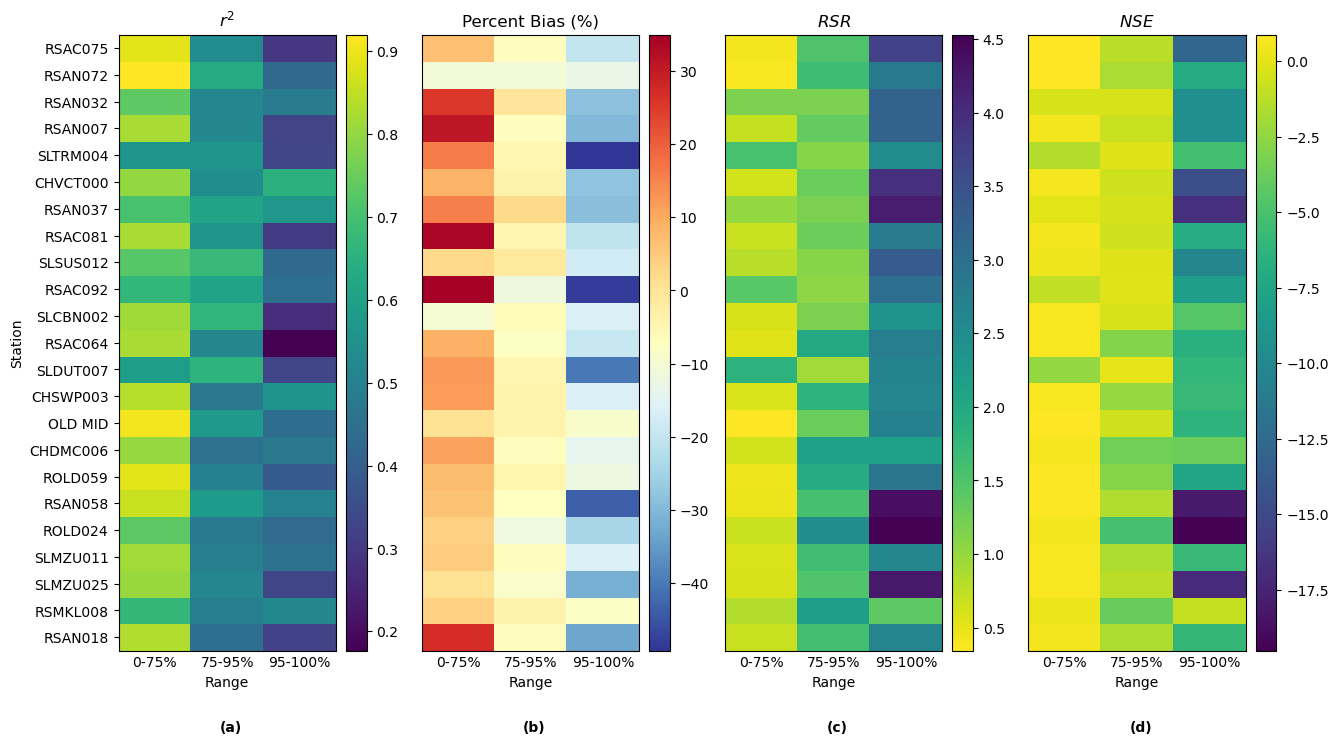

In [25]:
# plot percentile results for key stations
key_stations_only=False
# key_stations = ['RSAN018', 'RSAC092', 'CHSWP003', 'CHDMC006', 'SLMZU025', 'ROLD059', 'CHVT000','CVP_Intake', 'CCFB_Intake','Emmaton','Jersey_Point']
# key_stations = ['CVPIntake', 'CCFBIntake','Emmaton','JerseyPoint']

station_orders = {s:ii for ii, s in enumerate(observed_stations_ordered_by_median)}

key_station_mappings = {'JerseyPoint':'Jersey Point',#'RSAN018',
                        'Emmaton':'Emmaton',#'RSAC092', 
                        'CCFBIntake':'CCFB Intake',#'CHSWP003',
                        'CVPIntake':'CVP Intake',#'CHDMC006',
                        'SLMZU025':'SLMZU025',
                        'ROLD059':'ROLD059'}
# train and test results plot in different figures

stations = []
simplified_station_names = []
if key_stations_only:
    for s in list(range_results.keys()):
        for k in key_stations:
            new_s = s.replace('_','').replace('-','').replace(' ','')
            if k.lower() in new_s.lower():
                stations.append(s)
                simplified_station_names.append(key_station_mappings[k])
else:
    for s in list(range_results.keys()):
        new_s = s.split('-')[0].replace('_',' ').replace('-',' ')
        stations.append(s)
        simplified_station_names.append(new_s)
simplified_station_names = [x for _, x in sorted(zip(stations, simplified_station_names), key=lambda pair: station_orders[pair[0]],reverse=True)]
stations = [x for x in sorted(stations, key=lambda s: station_orders[s],reverse=True)]

# legends = ['{0:>3} ~ {1:<3}%'.format(s1, s2) for _ in datasets_to_plot for (s1, s2) in zip(percentiles[1:],percentiles[:-1])]

# fig_name_prefix = os.path.join(result_path,'20220225_models/images/MTL_Range_Performance')
plot_metrics=['r^2','Bias','RSR','NSE']
fig, ax = plt.subplots(nrows=1,ncols=len(plot_metrics),figsize=(15,8))
# plt.subplots_adjust(wspace=0.1)

for ii, metric in enumerate(plot_metrics):
    cmap='viridis'
    plot_metric = metric
    if metric=='r^2':
        plot_metric = 'R'
    elif metric=='RSR':
        plot_metric = 'NSE'
        cmap='viridis_r'
    elif metric =='Bias':
        # cmap = Pbias_map
        cmap = 'RdYlBu_r'

    to_plot=np.zeros([len(stations),len(percentiles)])
    for x_loc, station in enumerate(stations):
        for y_loc, percentile_range in enumerate(percentiles):
            if metric=='r^2':
                to_plot[x_loc,y_loc] = range_results[station][int(percentile_range*100)][plot_metric]**2
            elif metric=='RSR':
                to_plot[x_loc,y_loc] = np.sqrt(1-range_results[station][int(percentile_range*100)][plot_metric])
            else:
                to_plot[x_loc,y_loc] = range_results[station][int(percentile_range*100)][plot_metric]

    # if metric=='r^2':
    #     current_plot = ax[ii].pcolor(to_plot,vmin=0, vmax=1)
    # else:
    current_plot = ax[ii].pcolor(to_plot,cmap=cmap)
    plt.colorbar(current_plot,ax=ax[ii],aspect=30,fraction=0.1, pad=0.04)
    if metric =='Bias':
        ax[ii].set_title('Percent Bias (%)')
    else:
        ax[ii].set_title(r'${}$'.format(metric))
    if ii == 0:
        ax[ii].set_ylabel('Station')
        ax[ii].set_yticks(np.arange(len(stations))+0.5)
        ax[ii].set_yticklabels(simplified_station_names)
        # ax.tick_params(axis='y', labelrotation = 45, size=0)        
    else:
        ax[ii].set_yticks([])

    ax[ii].set_xlabel('Range')
    ax[ii].set_xticks(np.arange(len(percentiles))+0.5)
    ax[ii].xaxis.set_tick_params(size=0)
    ax[ii].set_xticklabels(['0-%d%%'%(percentiles[1]*100),'%d-%d%%'%(percentiles[1]*100,percentiles[2]*100),'%d-100%%'%(percentiles[2]*100)],fontsize=10)

    ax[ii].text(1.4, ax[ii].get_ylim()[0]-3,
                '(%s)'%chr(97+ii),weight='bold')
if save_results:
    fig_savepath = os.path.join(local_root_path,"images/%s_Range_Performance.png"% (model_path_prefix))
    plt.savefig(fig_savepath,bbox_inches='tight',dpi=300)
    print('Figure saved as %s' % fig_savepath)